# Práctico 1

# Integrantes:

<b> Esteban Arrúa 

<b> Matías Cattaneo

En este práctico, correspondiente a la primera mitad de la materia, trabajaremos con un dataset extraído de Twitter. La idea es emplear los conceptos de grafos vistos en clase sobre un caso real de actualidad.

## Dataset

El dataset consiste en un conjunto de hilos de tweets, con un total de ~150000 tweets, extraídos entre Enero y Marzo de 2021. La temática de los mismos está referida a la vacunación contra el covid-19 en Argentina.

Pueden descargar el dataset del siguiente [link](https://drive.google.com/file/d/1X_qKsE8muAnom2tDX4sLlmBAO0Ikfe_G/view?usp=sharing).

### Campos

- **created_at:** Fecha del tweet
- **id_str:** ID del tweet
- **full_text:** Contenido del tweet
- **in_reply_to_status_id:** ID del tweet inmediatamente anterior en el hilo
- **in_reply_to_user_id:** Autor del tweet inmediatamente anterior en el hilo
- **user.id:** Autor del tweet
- **user_retweeters:** Lista de ID de usuarios que retweetearon el tweet
- **sentiment:** Etiquetado manual que indica el sentimiento o intención del tweet con respecto al tweet anterior en el hilo

## Configuración inicial

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import nltk
import itertools

# ## Descargar el csv con los datos en este directorio
# DATA_DIR = Path('../data/twitter')
# INPUT_FILE = DATA_DIR / 'vacunas.csv'

# ## Creamos el directorio en caso de que no exista
# DATA_DIR.mkdir(parents=True, exist_ok=True)

### Cargamos el dataset

In [2]:
dtypes = {
    'id_str': str,
    'full_text': str,
    'in_reply_to_status_id': str,
    'in_reply_to_user_id': str,
    'user.id': str
}

path='../data/vacunas.csv'
df = pd.read_csv(path, dtype=dtypes).dropna(subset=['user_retweeters'])
df['user_retweeters'] = df['user_retweeters'].apply(lambda x: [str(elem) for elem in eval(x)])
print(df.shape)
df.head()

(155123, 8)


,created_at,id_str,full_text,in_reply_to_status_id,in_reply_to_user_id,user.id,user_retweeters,sentiment
0,Sat Feb 20 03:09:10 +0000 2021,1362962469749153792,Seguimos esperando el comunicado de @norabar r...,NaN,NaN,2737379453,"[2258074658, 159909978, 105301854, 290671142, ...",NaN
1,Sat Feb 20 03:19:59 +0000 2021,1362965193509265417,@Clon_43 @norabar Nora estaba indignada porque...,1362962469749153792,2737379453,32718111,[],NaN
2,Mon Feb 22 23:55:08 +0000 2021,1364000806740111363,"Bueno, Alberto dijo Salud o Economía. La salud...",NaN,NaN,252168075,"[1238117630696972289, 37232479, 12792246571247...",NaN
3,Tue Feb 23 00:09:14 +0000 2021,1364004354374696963,@spitta1969 Tuit del mes Spitta,1364000806740111363,252168075,1156346340802224128,[],NaN
4,Tue Feb 23 00:00:17 +0000 2021,1364002100364128260,@spitta1969 Estas onfire,1364000806740111363,252168075,153663816,[],NaN


### Observamos algunos ejemplos

In [3]:
idx = 0
print('Texto:', df.full_text.values[idx])
print('Retweets:', len(df.user_retweeters.values[idx]))

Texto: Seguimos esperando el comunicado de @norabar repudiando la situación respecto del gobierno y el tema vacunas. Seamos pacientes que con esto de la pandemia anda con mucho "laburo".
Retweets: 9


In [4]:
idx = 376
print('Text:', df.full_text.values[idx])
print('Retweets:', len(df.user_retweeters.values[idx]))

Text: Todo lo que hay que entender sobre la decisión –o no– de poner más vacunas en más brazos (por ejemplo, usar las 1º dosis en muchos y si es necesario retrasar la 2º) está en esta excelente nota de Nora Bär. https://t.co/A0I03DyxgO
Retweets: 48


### Calculamos la cantidad de hilos

In [5]:
roots = df[df['in_reply_to_user_id'].isna()]
roots.shape

(3174, 8)

## Actividades

### **1. Construcción del grafo** 

Construir el **grafo de retweets**, definido de la siguiente manera:

- Tipo de grafo: Dirigido
- Nodos: ID de los usuarios
- Enlaces: (Usuario A) ---> (Usuario B) si B retweeteó algún tweet de A

Con estos datos, el grafo debería tener alrededor de 40000 nodos y 90000 enlaces.

Considerar la versión no dirigida del grafo y estudiar su conectividad. Si existe una única "componente gigante", realizar el resto de las actividades sobre ella, en lugar de sobre el grafo completo.

Calcular las siguientes métricas globales del grafo:

- Grado medio
- Asortatividad
- Transitividad
- Coeficiente de clustering de Watts-Strogatz

**Opcional:** Comparar las métricas calculadas anteriormente con las de un grafo aleatorio con la misma distribución de grado. Pueden utilizar para ello este [método](https://networkx.org/documentation/stable/reference/generated/networkx.generators.degree_seq.configuration_model.html?highlight=configuration#networkx.generators.degree_seq.configuration_model). Con esto en mente, comentar si los valores obtenidos anteriormente difieren significativamente del caso aleatorio.


### **2. Centralidad**

Calcular 5 métricas de centralidad de nodos. Graficar la distribución de cada una de ellas ¿Existe alguna correlación entre las distintas centralidades? 

Hacer un ranking con los 10 nodos más centrales para cada métrica. ¿Hay coincidencia entre los rankings?. ¿Qué características tienen los usuarios más centrales y sus respectivos tweets?

**Opcional:** Determinar si existe alguna correlación entre la centralidad de un nodo y su actividad en red social. Es decir, evaluar si los usuarios que más escriben son los más centrales o no.

### **3. Comunidades**

Utilizar el algoritmo de Louvain con el parámetro "resolución" igual a 1. Caracterizar las comunidades halladas (cantidad, distribución de tamaños). Utilizar la modularidad y otras dos métricas a elección para evaluar la calidad de la partición encontrada. 

Variar el parámetro "resolución" y observar cómo cambia la distribución de comunidades encontradas. ¿Existe algún valor para el cual se identifiquen dos grandes comunidades?

Elegir otro algoritmo de detección de comunidades y comparar los resultados con los obtenidos anteriormente.

**Opcional:** Correr el algoritmo de Louvain con distintas semillas aleatorias. Utilizar alguna métrica de comparación externa entre las particiones obtenidas para determinar en qué medida depende el algoritmo de la condición inicial.

# Actividad 1: 

### **1. Construcción del grafo** 

Construir el **grafo de retweets**, definido de la siguiente manera:

- Tipo de grafo: Dirigido
- Nodos: ID de los usuarios
- Enlaces: (Usuario A) ---> (Usuario B) si B retweeteó algún tweet de A

Con estos datos, el grafo debería tener alrededor de 40000 nodos y 90000 enlaces.

Considerar la versión no dirigida del grafo y estudiar su conectividad. Si existe una única "componente gigante", realizar el resto de las actividades sobre ella, en lugar de sobre el grafo completo.

Calcular las siguientes métricas globales del grafo:

- Grado medio
- Asortatividad
- Transitividad
- Coeficiente de clustering de Watts-Strogatz

**Opcional:** Comparar las métricas calculadas anteriormente con las de un grafo aleatorio con la misma distribución de grado. Pueden utilizar para ello este [método](https://networkx.org/documentation/stable/reference/generated/networkx.generators.degree_seq.configuration_model.html?highlight=configuration#networkx.generators.degree_seq.configuration_model). Con esto en mente, comentar si los valores obtenidos anteriormente difieren significativamente del caso aleatorio.


In [57]:
df_enlaces=df[['user_retweeters','user.id']].explode('user_retweeters').reset_index(drop=True)
df_enlaces.drop_duplicates(inplace=True)   # Se eliminan enlaces duplicados
df_enlaces.dropna(inplace=True)
df_enlaces

,user_retweeters,user.id
0,2258074658,2737379453
1,159909978,2737379453
2,105301854,2737379453
3,290671142,2737379453
4,208721168,2737379453
...,...,...
320731,845504142374252544,127998837
320843,353854993,58065646
320906,1363288094,79840600
320907,2258074658,79840600


In [58]:
import networkx as nx

g_di = nx.from_pandas_edgelist(df_enlaces, source='user_retweeters', target='user.id',create_using=nx.DiGraph) 
print(nx.info(g_di))

Name: 
Type: DiGraph
Number of nodes: 39800
Number of edges: 93692
Average in degree:   2.3541
Average out degree:   2.3541


In [59]:
# Verificamos si la cantidad de usuarios coincide con el número de nodos. En la columna user_id no aparecen todos los nodos, por ejemplo un usuario que retweeteo 
# pero que no participó de los hilos.

len(set(df_enlaces['user.id'].tolist() + df_enlaces['user_retweeters'].tolist()))

39800

## Versión no dirigida

In [60]:
g = nx.from_pandas_edgelist(df_enlaces, source='user_retweeters', target='user.id',create_using=nx.Graph) 
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 39800
Number of edges: 93404
Average degree:   4.6937


### Matriz de adyacencia

In [61]:
A = nx.adjacency_matrix(g)
A=A.toarray()
print(A)

[[0 1 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


### Matriz Laplaciana

La conectividad se puede estudiar en términos de los autovalores de la matriz laplaciana (diferencia entre la matriz de grado y la de adyacencia L=D-A).

El segundo autovalor no nulo se denomina conectividad algebraica y es una medida de la conectividad del grafo (mas pequeño, mas modular)

In [62]:
L = nx.laplacian_matrix(g).toarray()
print(L)

[[19 -1  0 ...  0  0  0]
 [-1  9 -1 ...  0  0  0]
 [ 0 -1  1 ...  0  0  0]
 ...
 [ 0  0  0 ...  1  0  0]
 [ 0  0  0 ...  0  1  0]
 [ 0  0  0 ...  0  0  1]]


Podemos tambien usar la funcion algebraic_connectivity de Network x (es el segundo autovalor no nulo de la matriz Laplaciana)

In [63]:
nx.algebraic_connectivity(g)

0.0

Vemos que no es un grafo conexo. Se analizan para ello cada una de las componentes y la distribución.

In [64]:
Gcc = sorted(nx.connected_components(g), key=len, reverse=True)

In [65]:
for numero,component in enumerate(Gcc):
    print("Componente {} - tamaño: {}".format(numero,len(component)))

Componente 0 - tamaño: 38998
Componente 1 - tamaño: 106
Componente 2 - tamaño: 32
Componente 3 - tamaño: 22
Componente 4 - tamaño: 13
Componente 5 - tamaño: 8
Componente 6 - tamaño: 7
Componente 7 - tamaño: 7
Componente 8 - tamaño: 6
Componente 9 - tamaño: 5
Componente 10 - tamaño: 4
Componente 11 - tamaño: 4
Componente 12 - tamaño: 4
Componente 13 - tamaño: 4
Componente 14 - tamaño: 4
Componente 15 - tamaño: 4
Componente 16 - tamaño: 4
Componente 17 - tamaño: 3
Componente 18 - tamaño: 3
Componente 19 - tamaño: 3
Componente 20 - tamaño: 3
Componente 21 - tamaño: 3
Componente 22 - tamaño: 3
Componente 23 - tamaño: 3
Componente 24 - tamaño: 3
Componente 25 - tamaño: 3
Componente 26 - tamaño: 3
Componente 27 - tamaño: 3
Componente 28 - tamaño: 3
Componente 29 - tamaño: 3
Componente 30 - tamaño: 3
Componente 31 - tamaño: 3
Componente 32 - tamaño: 3
Componente 33 - tamaño: 3
Componente 34 - tamaño: 3
Componente 35 - tamaño: 3
Componente 36 - tamaño: 3
Componente 37 - tamaño: 3
Componente 38

Como puede observarse en el grafo a continuación, existen 57 componentes aisladas, 212 de tamaño 2 (un solo retweet). Nos vamos a quedar con la componente gigante (38998 nodos)

In [66]:
from collections import Counter

x = [len(c) for c in Gcc]
Counter(x)

Counter({38998: 1,
         106: 1,
         32: 1,
         22: 1,
         13: 1,
         8: 1,
         7: 2,
         6: 1,
         5: 1,
         4: 7,
         3: 29,
         2: 212,
         1: 57})

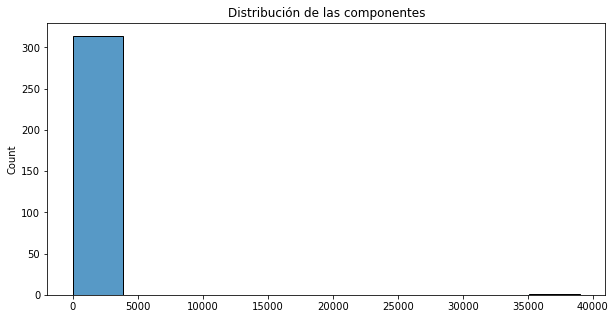

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

x = [len(c) for c in Gcc]
plt.figure(figsize=(10,5))
sns.histplot(x)
plt.title("Distribución de las componentes")
plt.show()

In [67]:
#Nos quedamos con la componente gigante

G = g.subgraph(Gcc[0])

nx.algebraic_connectivity(G)

0.014577205084482308

In [68]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 38998
Number of edges: 92830
Average degree:   4.7608


In [69]:
df_metricas=pd.DataFrame(G.degree()).rename(columns={0:'nodo',1:'degree'})

transitividad= nx.transitivity(G)
df_metricas['transitividad'] = transitividad
df_metricas['asortatividad']=(nx.degree_assortativity_coefficient(G))
df_metricas['watts_stogratz']=(nx.average_clustering(G))

In [70]:
df_metricas

,nodo,degree,transitividad,asortatividad,watts_stogratz
0,2258074658,19,0.001612,-0.222899,0.101898
1,2737379453,9,0.001612,-0.222899,0.101898
2,159909978,1,0.001612,-0.222899,0.101898
3,105301854,10,0.001612,-0.222899,0.101898
4,290671142,15,0.001612,-0.222899,0.101898
...,...,...,...,...,...
38993,2650545267,1,0.001612,-0.222899,0.101898
38994,339254354,6,0.001612,-0.222899,0.101898
38995,346605471,1,0.001612,-0.222899,0.101898
38996,58065646,1,0.001612,-0.222899,0.101898


## Opcional

In [53]:
nodos= 20
probabilidad= np.random.rand(20, 20) #matriz de probabilidades
adjacency = np.random.rand(*P.shape) <= P  #Armo la matriz de adyacencia
g_test = nx.from_numpy_matrix(adjacency, nx.DiGraph) 

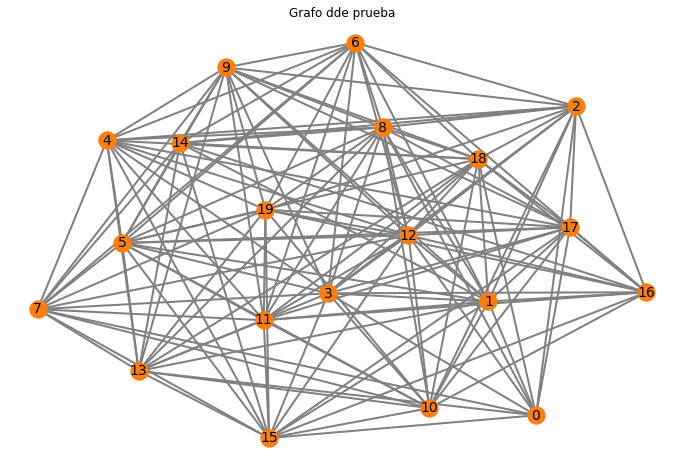

In [54]:
draw_params = dict(
    with_labels=True,               ## Incluye los nombres de los nodos
    node_color='C1',                ## Elijo el color 1 de la paleta de colores
    edge_color='gray',
    width=2,                        ## Espesor de los enlaces
    font_size=14,
    pos=nx.kamada_kawai_layout(g_test)   ## Algoritmo para embeber el grafo en el plano
)

fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Grafo dde prueba')
nx.draw(
    g_test, 
    ax=ax,
    **draw_params
)

In [55]:
df_metricas_test=pd.DataFrame(g_test.degree()).rename(columns={0:'nodo',1:'degree'})

transitividad= nx.transitivity(g_test)
df_metricas_test['transitividad'] = transitividad
df_metricas_test['asortatividad']=(nx.degree_assortativity_coefficient(g_test))
df_metricas_test['watts_stogratz']=(nx.average_clustering(g_test))

In [56]:
df_metricas_test

,nodo,degree,transitividad,asortatividad,watts_stogratz
0,0,12,0.75,0.023213,0.74832
1,1,16,0.75,0.023213,0.74832
2,2,16,0.75,0.023213,0.74832
3,3,16,0.75,0.023213,0.74832
4,4,16,0.75,0.023213,0.74832
5,5,16,0.75,0.023213,0.74832
6,6,16,0.75,0.023213,0.74832
7,7,13,0.75,0.023213,0.74832
8,8,16,0.75,0.023213,0.74832
9,9,17,0.75,0.023213,0.74832


La transitividad es mas elevada porque todos los nodos tienen un nodos adyacentes interconectados. La asortatividad también es mayor al haber menor variación en el grado de los nodos, existiendo mayor correlación entre ellos.

# Actividad 2: Centralidad

Calcular 5 métricas de centralidad de nodos. Graficar la distribución de cada una de ellas ¿Existe alguna correlación entre las distintas centralidades? 

Hacer un ranking con los 10 nodos más centrales para cada métrica. ¿Hay coincidencia entre los rankings?. ¿Qué características tienen los usuarios más centrales y sus respectivos tweets?

**Opcional:** Determinar si existe alguna correlación entre la centralidad de un nodo y su actividad en red social. Es decir, evaluar si los usuarios que más escriben son los más centrales o no.

In [72]:
from dask.distributed import Client
import dask 

client = Client(n_workers=5, memory_limit='3.25 GB')
client

Client Scheduler: tcp://127.0.0.1:62117 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 5 Cores: 15 Memory: 16.25 GB


In [71]:
client.close()

NameError: name 'client' is not defined

In [77]:
metricas=['degree','betweenness_centrality','eigenvector_centrality','closeness_centrality','pagerank','transitividad']

dict_metricas=dict([(key,[])for key in metricas])

def calculo_metricas(metrica,dict_metricas_):
    if metrica=='degree':
        degree = G.degree()
        dict_metricas_['degree'].append(degree)
    elif metrica=='betweenness_centrality':
        betweenness = nx.betweenness_centrality(G)
        dict_metricas_['betweenness_centrality'].append(betweenness)
    elif metrica=='eigenvector_centrality':
        eigenvector = nx.eigenvector_centrality(G,max_iter=3000)
        dict_metricas_['eigenvector_centrality'].append(eigenvector)
    elif metrica=='closeness_centrality':
        closeness = nx.closeness_centrality(G)
        dict_metricas_['closeness_centrality'].append(closeness)
    # elif metrica=='katz_centrality':
        # katz = nx.katz_centrality(G,max_iter=3000)   PowerIterationFailedConvergence(...), 'power iteration failed to converge within 3000 iterations')
        # dict_metricas_['katz_centrality'].append(katz)
    elif metrica=='transitividad':
        clustering_coefficient = nx.clustering(G)
        dict_metricas_['transitividad'] = list(clustering_coefficient.values())
    elif metrica=='pagerank':
        pagerank = nx.pagerank(G,max_iter=3000)
        dict_metricas_['pagerank'].append(pagerank)
    
    return dict_metricas_
        
calculo_metricas_delayed=dask.delayed(calculo_metricas)

results=[]

for metrica in metricas:

    result=calculo_metricas_delayed(metrica,dict_metricas)

    results.append(result)

resultados=dask.compute(*results)
    

In [132]:
degree=pd.DataFrame(resultados[0]['degree']).T.rename(columns={0:'degree'})
degree['nodo'], degree['degree'] = degree['degree'].str
degree.set_index('nodo',inplace=True)
betweenness_centrality=pd.DataFrame(resultados[1]['betweenness_centrality']).T.rename(columns={0:'betweenness_centrality'})
eigenvector_centrality=pd.DataFrame(resultados[2]['eigenvector_centrality']).T.rename(columns={0:'eigenvector_centrality'})
closeness_centrality=pd.DataFrame(resultados[3]['closeness_centrality']).T.rename(columns={0:'closeness_centrality'})
pagerank=pd.DataFrame(resultados[4]['pagerank']).T.rename(columns={0:'pagerank'})
transitividad=pd.DataFrame(resultados[5]['transitividad']).rename(columns={0:'transitividad'}).set_index(degree.index)

df_centralidad=pd.concat([degree,betweenness_centrality,eigenvector_centrality,closeness_centrality,pagerank,transitividad],axis=1)

df_centralidad.to_csv('df_centralidad.csv')

df_centralidad

,degree,betweenness_centrality,eigenvector_centrality,closeness_centrality,pagerank,transitividad
nodo,,,,,,
2258074658,19,0.000172,3.448815e-03,0.286305,0.000070,0.052632
2737379453,9,0.000103,2.833440e-04,0.244898,0.000039,0.000000
159909978,1,0.000000,2.839120e-06,0.196722,0.000007,0.000000
105301854,10,0.000041,4.052027e-03,0.304398,0.000037,0.066667
290671142,15,0.000383,4.511587e-03,0.308014,0.000057,0.066667
...,...,...,...,...,...,...
2650545267,1,0.000000,6.605328e-07,0.182163,0.000009,0.000000
339254354,6,0.000056,1.766916e-04,0.276895,0.000032,0.000000
346605471,1,0.000000,1.769656e-06,0.216851,0.000008,0.000000


## Distribución y análisis de métricas de centralidad

In [137]:
df_centralidad=pd.read_csv('df_centralidad.csv').rename(columns={'Unnamed: 0':'nodo'})
df_centralidad.nodo=df_centralidad.astype(str)
df_centralidad.set_index('nodo',inplace=True)

In [138]:
list(enumerate(df_centralidad.columns))

[(0, 'degree'),
 (1, 'betweenness_centrality'),
 (2, 'eigenvector_centrality'),
 (3, 'closeness_centrality'),
 (4, 'pagerank'),
 (5, 'transitividad')]

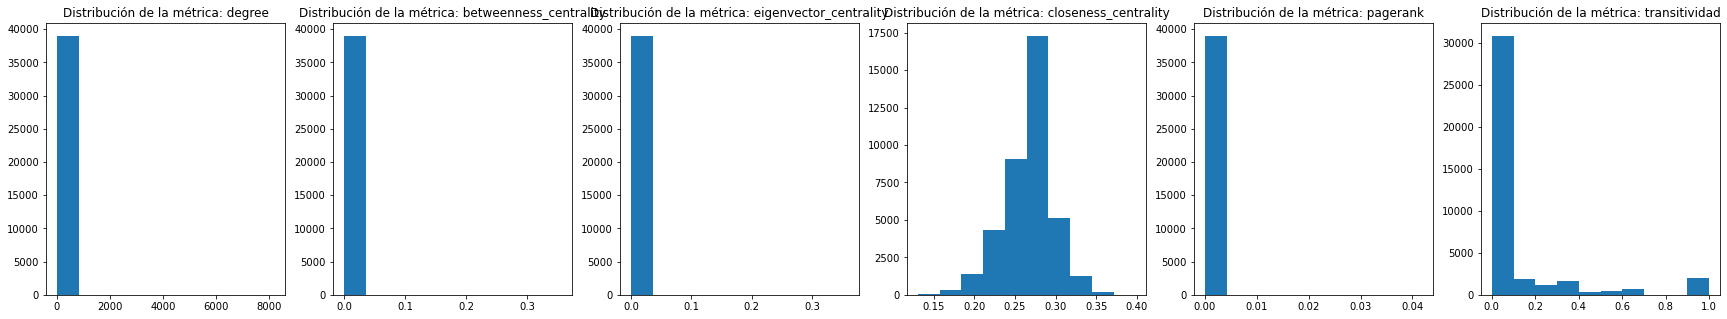

In [140]:
fig, axs=plt.subplots(nrows=1,ncols=6,sharex=False,figsize=(30,5))

for i,metrica in enumerate(df_centralidad.columns):
    axs[i].hist(df_centralidad[metrica])
    axs[i].set_title('Distribución de la métrica: {}'.format(metrica))

Análisis de las distribuciones: 

*Degree: vemos que gran parte de los nodos presenta grado entre 1 y 3, habiendo sin embargo algunos que llegan incluso a conectarse con 8000 nodos.

*Betweenness: Vemos que existen algunos nodos que actuan como "puentes" en el grafo, teniendo betweeness mas alto. Sin embargo, para la mayoría de los nodos esta métrica es muy baja. 

*Eigenvector: Esta métrica es muy baja para la mayoría de los nodos, pero y deberá tener una correlación muy fuerte con el grado del nodo y con pagerank, como es de esperar.

*Transitividad: Vemos que la mayoría de los nodos no tiene nodos adyacentes interconectados.  Sin embargo existen algunos de clara importancia.


In [141]:
df_centralidad.describe()

,degree,betweenness_centrality,eigenvector_centrality,closeness_centrality,pagerank,transitividad
count,38998.000000,38998.000000,3.899800e+04,38998.000000,38998.000000,38998.000000
mean,4.760757,0.000071,2.537567e-03,0.268301,0.000026,0.101898
std,70.009010,0.002705,4.382190e-03,0.030144,0.000412,0.244696
min,1.000000,0.000000,1.347997e-11,0.130407,0.000006,0.000000
25%,1.000000,0.000000,2.225366e-04,0.254825,0.000009,0.000000
50%,1.000000,0.000000,2.437621e-03,0.272840,0.000010,0.000000
75%,3.000000,0.000003,3.550974e-03,0.284754,0.000015,0.000000
max,8207.000000,0.355536,3.597697e-01,0.398115,0.041886,1.000000


[]

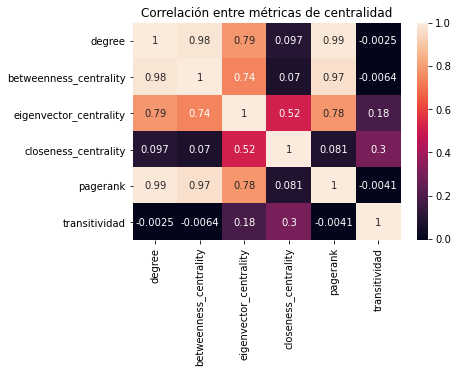

In [143]:
sns.heatmap(df_centralidad.corr(),annot=True)
plt.title('Correlación entre métricas de centralidad')
plt.plot()

Se observa una alta correlación entre el grado y el de centralidad del vector, betweenness, así como también con pagerank.Sin embargo no se observa una correlación con la centralidad de cercanía.

## Ranking de 10 nodos por cada métrica

In [145]:
nodos_betweenness_centrality=df_centralidad.betweenness_centrality.sort_values(ascending=False)[:10].reset_index()
nodos_betweenness_centrality

,nodo,betweenness_centrality
0,252168075,0.355536
1,130979339,0.234780
2,73102744,0.165649
3,593189095,0.149828
4,931564592328781824,0.129880
5,367933714,0.120725
6,2687724840,0.099197
7,144929758,0.092908
8,312708081,0.035541
9,593340893,0.023739


In [146]:
nodos_eigenvector_centrality=df_centralidad.eigenvector_centrality.sort_values(ascending=False)[:10].reset_index()
nodos_eigenvector_centrality

,nodo,eigenvector_centrality
0,130979339,0.359770
1,73102744,0.349410
2,252168075,0.279856
3,367933714,0.257117
4,2687724840,0.179581
5,593189095,0.127902
6,312708081,0.121404
7,144929758,0.115650
8,931564592328781824,0.098888
9,959033548379508736,0.032709


In [147]:
nodos_closeness_centrality=df_centralidad.closeness_centrality.sort_values(ascending=False)[:10].reset_index()
nodos_closeness_centrality

,nodo,closeness_centrality
0,130979339,0.398115
1,206371045,0.397693
2,950696136,0.397203
3,1116405885226688512,0.395664
4,1283193788744204296,0.394395
5,252168075,0.392229
6,593340893,0.388409
7,37063681,0.387109
8,827048251,0.382545
9,367933714,0.382177


In [148]:
nodos_pagerank=df_centralidad.pagerank.sort_values(ascending=False)[:10].reset_index()
nodos_pagerank

,nodo,pagerank
0,252168075,0.041886
1,130979339,0.034791
2,73102744,0.032291
3,593189095,0.030892
4,367933714,0.023018
5,2687724840,0.020318
6,144929758,0.017320
7,931564592328781824,0.015454
8,312708081,0.008865
9,1077176953,0.003753


In [149]:
nodos_degree=df_centralidad.degree.sort_values(ascending=False)[:10].reset_index()
nodos_degree

,nodo,degree
0,252168075,8207
1,130979339,5553
2,73102744,5362
3,367933714,3849
4,593189095,3834
5,2687724840,3175
6,931564592328781824,3136
7,144929758,2657
8,312708081,1630
9,1077176953,589


A continuación calculamos la coincidencia en el ranking para todas las métricas.  Como se puede observar, existen 3 nodos comunes a todas las métricas. Es importante destacar que existen métricas que están mas altamente correlacionadas que otras, y por ellos existen coincidencias mayores.

In [151]:
nodos_comunes=[nodos_betweenness_centrality.nodo.tolist(),nodos_closeness_centrality.nodo.tolist(),nodos_degree.nodo.tolist()
               ,nodos_eigenvector_centrality.nodo.tolist(),nodos_pagerank.nodo.tolist()]

nodos_centrales=set(nodos_comunes[0]).intersection(*nodos_comunes[1:])

nodos_centrales


{'130979339', '252168075', '367933714'}

130979339: @norabar Ex editora de Ciencia y Salud en La Nación. Ahora, en  @eldestapeweb "Rebelión en el Laboratorio" y "Diez preguntas que la ciencia (todavía) no puede contestar".

252168075: @spitta1969 Candidata a Diputada Nacional; Farmacéutica/Biotecnóloga; Una Mafalda actual. #RecuperemosArgentina

367933714: @rquiroga777 Bioquímico, Dr. en Cs Químicas, dedicado a la bioinformática. Docente en la FCQ-UNC. Investigador CONICET. Tuiteo sobre política, ciencia y análisis de datos.

Son todos perfiles muy activos e importantes en tweeter, teniendo varios miles de seguidores. @Norabar es el mas importante, con casi 150 mil.

Vamos a analizar los tweets de estos usuarios

In [152]:
def plot_wordcloud(user_id):

    from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
    # Importamos esta libreria que nos permite reemplazar caracteres
    import re
    import nltk

    # Importamos la función que nos permite Stemmizar de nltk y definimos el stemmer
    from nltk.stem import SnowballStemmer
    from wordcloud import WordCloud
    
    spanish_stemmer = SnowballStemmer('spanish')

    stopwords = set(nltk.corpus.stopwords.words('spanish'))
    tokenizer = RegexpTokenizer(r'\w+')

    df_analisis=df[['full_text','user.id','user_retweeters']].explode('user_retweeters').reset_index(drop=True)
    df_analisis=df_analisis[(df_analisis['user.id'].isin(user_id) | df_analisis.user_retweeters.isin(user_id))]
    df_analisis.drop_duplicates('full_text',inplace=True)
    df_analisis.reset_index(inplace=True,drop=True)

    
    todos_retweets = []
    for i in range(df_analisis.shape[0]):
        text = df_analisis.full_text[i] #seleccionar el titular
        # Vamos a reemplzar los caracteres que no sean leras por espacios
        text=re.sub("[^a-zA-Z]"," ",str(text))
        # Pasamos todo a minúsculas
        text=text.lower()
        text = tokenizer.tokenize(text) # Tokenizar con RegexpTokenizer
        text = [w for w in text if w not in stopwords]# Filtrar por stopwords
        text = [wrd for wrd in text if len(wrd) > 4]
        # Aplicamos la funcion para buscar la raiz de las palabras
        #text = [spanish_stemmer.stem(w) for w in text]
        todos_retweets.append(text) #agregar el resultado a la lista

    
    todos_retweets = list(itertools.chain(*todos_retweets))

    freq_todos_retweets = nltk.FreqDist(todos_retweets)

    df_todos_retweets = pd.DataFrame(list(freq_todos_retweets.items()),columns=['Words','Frequency'])

    # ordenar por frecuencia

    df_todos_retweets.sort_values(by='Frequency',ascending=False,inplace=True)
    df_todos_retweets.reset_index(drop=True,inplace=True)

    plt.figure(figsize = (15,8))
    plot = sns.barplot(x  = df_todos_retweets.iloc[:30].Words, y = df_todos_retweets.iloc[:30].Frequency)
    for item in plot.get_xticklabels():
        item.set_rotation(90)
    plt.title(user_id)
    plt.show()
    
    text=' '.join(df_todos_retweets.Words)

    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    plt.figure(figsize=(15,15))
    plt.title(user_id)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

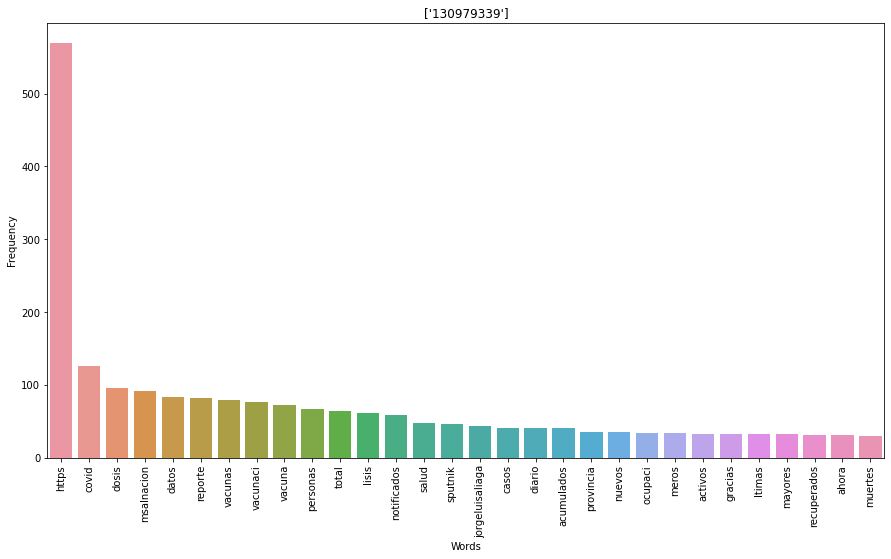

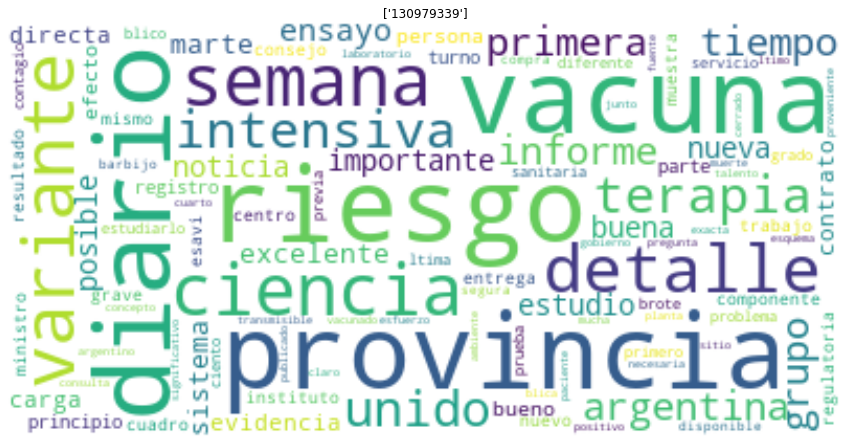

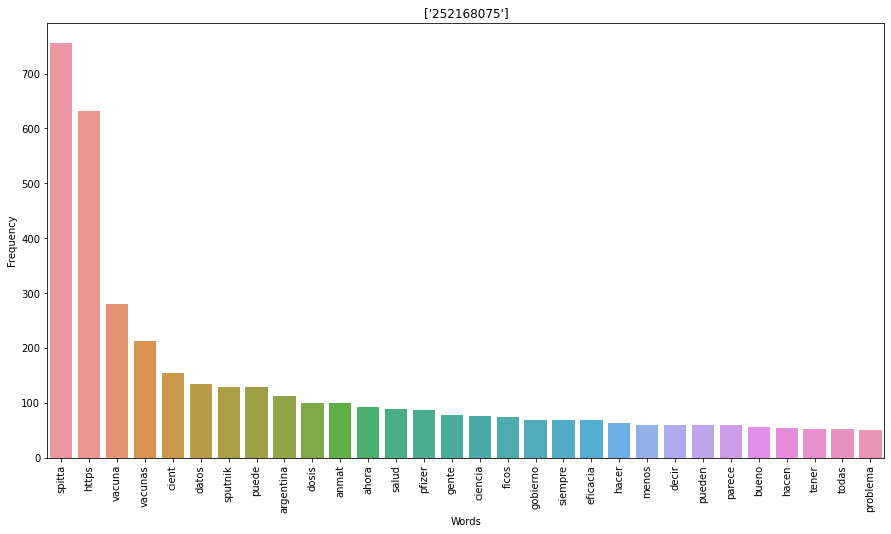

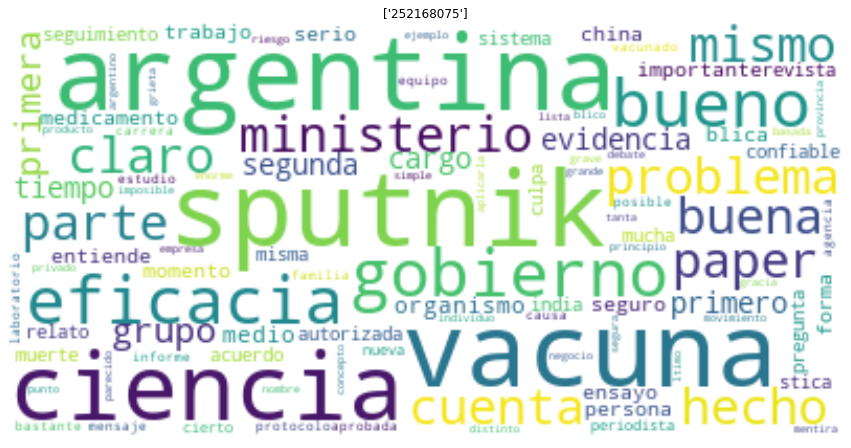

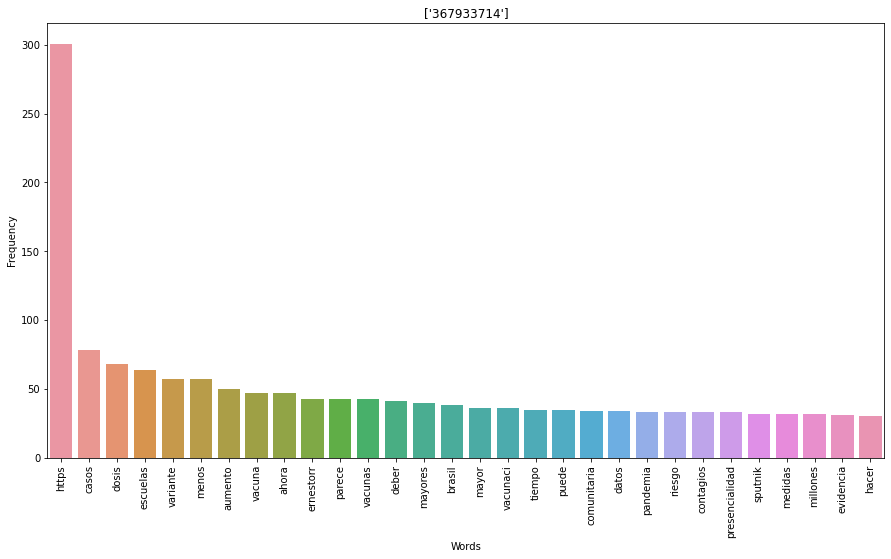

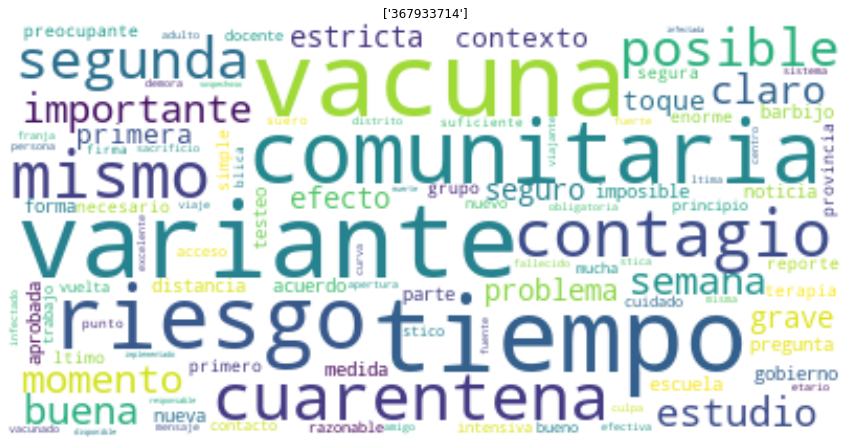

In [153]:
for user in nodos_centrales:
    plot_wordcloud([user])

# Actividad 3: Comunidades

Utilizar el algoritmo de Louvain con el parámetro "resolución" igual a 1. Caracterizar las comunidades halladas (cantidad, distribución de tamaños). Utilizar la modularidad y otras dos métricas a elección para evaluar la calidad de la partición encontrada. 

Variar el parámetro "resolución" y observar cómo cambia la distribución de comunidades encontradas. ¿Existe algún valor para el cual se identifiquen dos grandes comunidades?

Elegir otro algoritmo de detección de comunidades y comparar los resultados con los obtenidos anteriormente.

**Opcional:** Correr el algoritmo de Louvain con distintas semillas aleatorias. Utilizar alguna métrica de comparación externa entre las particiones obtenidas para determinar en qué medida depende el algoritmo de la condición inicial.

In [12]:
from cdlib import NodeClustering, evaluation, algorithms

comms = algorithms.louvain(G, weight='weight', resolution=1, randomize=False)

In [34]:
print("Se han encontrado: {} comunidades".format(len(comms.communities)))

Se han encontrado: 49 comunidades


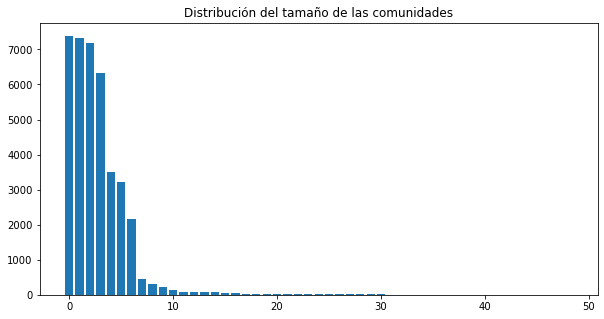

In [49]:
len_comunidades=[]

for community in comms.communities:
    len_comunidades.append(len(community))

plt.figure(figsize=(10,5))
plt.bar(height=len_comunidades,x=np.arange(49))
plt.title("Distribución del tamaño de las comunidades")
plt.show()

### Calidad de las comunidades encontradas

<b>Densidad interna

In [50]:
m = G.number_of_edges()
N = G.number_of_nodes()
print('Densidad del grafo:', m/(N*(N-1)/2))
print('Comunidades encontradas:', evaluation.internal_edge_density(G, comms))

Densidad del grafo: 0.0001220800821062
Comunidades encontradas: FitnessResult(min=0.00036631399268824796, max=1.0, score=0.20659699799889067, std=0.22650452458270795)


En este caso es esperable que la densidad promedio de las comunidades sea mayor que la del grafo, lo cual nos habla de que los nodos se encuentran mas concentrados.

<b>Indice de corte

In [52]:
print('Comunidades encontradas:', evaluation.cut_ratio(G, comms))

Comunidades encontradas: FitnessResult(min=1.1162009876146339e-06, max=4.488330341113106e-05, score=1.8003645224510343e-05, std=1.2383976256670243e-05)


<b>Modularidad

In [51]:
print('Comunidades encontradas:', evaluation.newman_girvan_modularity(G, comms))

Comunidades encontradas: FitnessResult(min=None, max=None, score=0.5611511925585891, std=None)


En este caso encontramos que existen grandes diferencias entre los tamaños de las comunidades, por lo cual deberemos encontrar el límite de resolución

In [58]:
def run_louvain(g, min_res, max_res, samples=10, logspace=True):
    comms_dict = {}
    if logspace:
        resolutions = np.logspace(np.log10(min_res), np.log10(max_res), samples)
    else:
        resolutions = np.linspace(min_res, max_res, samples)
    for resolution in resolutions:
        comms = algorithms.louvain(
            g, weight='weight', resolution=resolution, randomize=False
        )
        comms_dict[resolution] = comms
    return comms_dict


def plot_louvain(g, min_res, max_res, samples=10, logspace=True):
    comms_dict = run_louvain(g, 0.01, 10, samples=200)
    resolutions = comms_dict.keys()
    Q_values = [evaluation.newman_girvan_modularity(g, comms).score for comms in comms_dict.values()]
    fig, ax = plt.subplots(figsize=(12,5))
    ax.set_ylabel('Q')
    ax.set_xlabel('Resolution')
    ax.set_xscale('log')
    ax.plot(resolutions, Q_values, '-', label='Louvain')
    ax.legend()
    return ax

A continuación vemos como varía la modularidad en función a la resolución. Vemos que el máximo de resolución esta en torno al valor 1.

<AxesSubplot:xlabel='Resolution', ylabel='Q'>

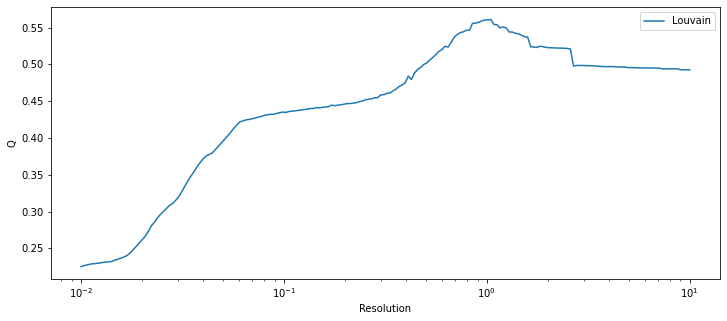

In [60]:
plot_louvain(G, min_res=0.01, max_res=10, samples=200, logspace=True)

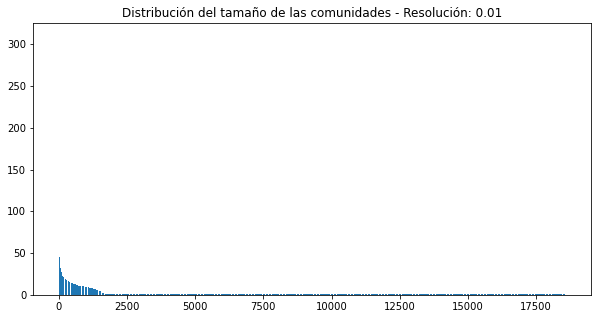

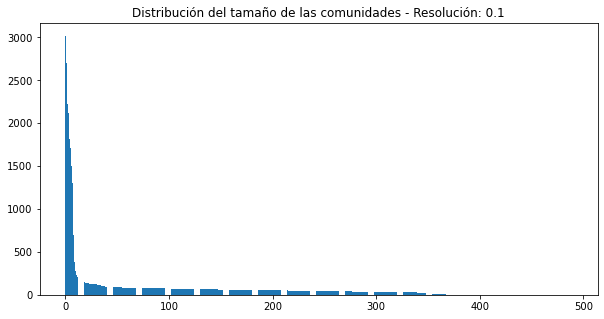

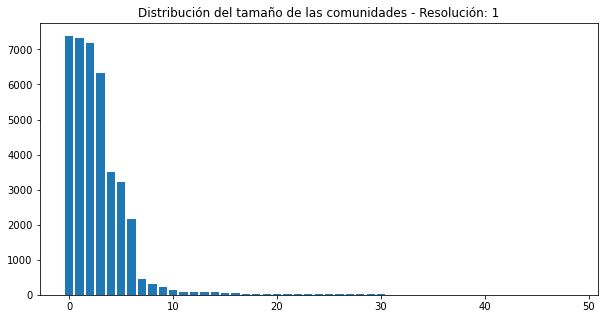

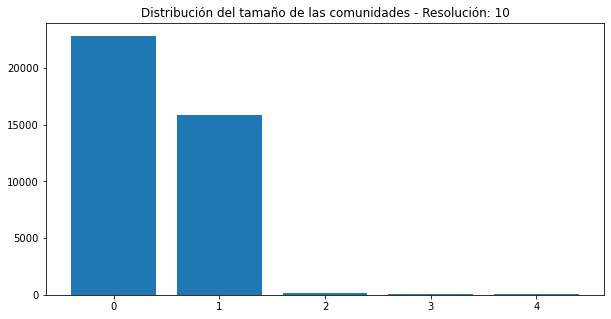

In [76]:
resolutions = [0.01,0.1, 1, 10]
comms_dict = {} #diccionario que contendrá las comunidades para cada una de las resolucione
for resolution in resolutions:
    comms = algorithms.louvain(G, weight='weight', resolution=resolution, randomize=False)
    comms_dict[resolution] = comms 

#Graficamos la distribución para distintos valores de resolución

for i,key in enumerate(comms_dict):

    plt.figure(figsize=(10,5))
    plt.bar(height=[len(com) for com in comms_dict[key].communities],x=np.arange(len([len(com) for com in comms_dict[key].communities])))
    plt.title("Distribución del tamaño de las comunidades - Resolución: {}".format(resolutions[i]))
    plt.show()

Vemos que con una resolución de 10 se empiezan a observar claramente dos comunidades bien definidas.

In [15]:
from dask.distributed import Client
import dask 

client = Client(n_workers=5, memory_limit='3.25 GB')
client

Client Scheduler: tcp://127.0.0.1:51363 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 5 Cores: 15 Memory: 16.25 GB


In [ ]:
#No se pudo ejecutar. En un día no se pudo terminar ni un solo proceso..

levels = range(1, 16)
data = []

def calculo_modularidad(level):

    comms = algorithms.girvan_newman(G, level=level)
    ncomms = len(comms.communities)
    Q = evaluation.newman_girvan_modularity(G, comms).score

    return level,ncomms,Q

calculo_modularidad_delayed=dask.delayed(calculo_modularidad)

results=[]

for level in levels:

    result=calculo_modularidad_delayed(level)

    results.append(result)

resultados=dask.compute(*results)

<b>ALGORITMO DE LEIDEN

In [26]:
comms_leiden = algorithms.leiden(G)

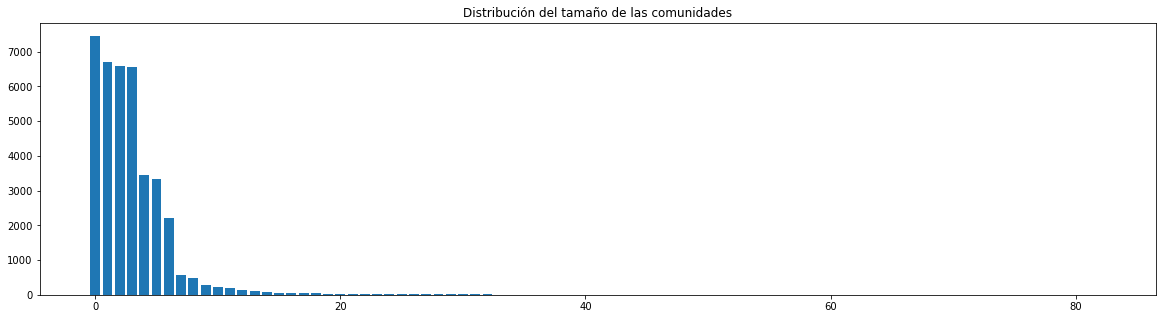

In [27]:
len_comunidades=[]

for community in comms_labelpropagation.communities:
    len_comunidades.append(len(community))

plt.figure(figsize=(20,5))
plt.bar(height=len_comunidades,x=np.arange(len(len_comunidades)))
plt.title("Distribución del tamaño de las comunidades")
plt.show()

Con este algoritmo se han obtenido 83 comunidades, algo más que en el algoritmo de Louvain con la resolución optima. También se hicieron pruebas con label propagation, pero el número de comunidades ascendía a 715.

<b>Densidad interna

In [29]:
m = G.number_of_edges()
N = G.number_of_nodes()
print('Densidad del grafo:', m/(N*(N-1)/2))
print('Comunidades encontradas:', evaluation.internal_edge_density(G, comms_leiden))

Densidad del grafo: 0.0001220800821062
Comunidades encontradas: FitnessResult(min=0.0003456916294240868, max=3.0, score=0.37777099493066146, std=0.4632439371155914)


En este caso es esperable que la densidad promedio de las comunidades sea mayor que la del grafo, lo cual nos habla de que los nodos se encuentran mas concentrados. Esta métrica da mejor que con el algoritmo de Louvain (0.20)

<b>Indice de corte

In [30]:
print('Comunidades encontradas:', evaluation.cut_ratio(G, comms_leiden))

Comunidades encontradas: FitnessResult(min=1.1162009876146339e-06, max=4.763003916654759e-05, score=1.6871358416519227e-05, std=1.063337949721832e-05)


<b>Modularidad

In [31]:
print('Comunidades encontradas:', evaluation.newman_girvan_modularity(G, comms_leiden))

Comunidades encontradas: FitnessResult(min=None, max=None, score=0.5831082024551485, std=None)


La modularidad en este caso es casi la misma que la obtenida con el algoritmo de Louvain.